In [1]:
# import numpy as np

## Kalman Filter: ToDo

## Unscented KF

In [21]:
import numpy as np
from Filtering.KalmanFilters import UnscentedKF
from Filtering.ExampleModels import SimpleModel
import matplotlib.pyplot as plt

In [10]:
np.random.seed(0)

In [13]:
omega = 4e-2
phi = 0.5
gamma_shape = 2
gamma_scale = 2
obs_noise_std = 0.5

simple_model = SimpleModel(omega, phi, gamma_shape, gamma_scale, obs_noise_std)

In [14]:
state_dim = 1
obs_dim = 1

true_init_state = 1.

t_steps = np.arange(1, 61, 1)*1.
n_steps = len(t_steps)

In [15]:
true_state = np.zeros((n_steps, state_dim))
true_obs = np.zeros((n_steps, obs_dim))

true_state[0, :] = true_init_state
true_obs[0, :] = 0. # Not used

for i in range(0, n_steps - 1):
    current_time = t_steps[i]
    next_time = t_steps[i + 1]
    
    true_state[i + 1, :] = simple_model.forward_model(true_state[i], current_time, with_noise=True)
    true_obs[i + 1, :] = simple_model.observation_operator(true_state[i + 1, :], next_time, with_noise=True)

In [16]:
state_dim = 1
obs_dim = 1

alpha = 0.001
beta = 2
kappa = 0

ukf_obj = UnscentedKF(state_dim, obs_dim, alpha, beta, kappa, simple_model)

In [17]:
propagated_state_mean = np.zeros((n_steps, state_dim))
propagated_state_cov = np.zeros((n_steps, state_dim, state_dim))

propagated_obs_mean = np.zeros((n_steps, obs_dim))
propagated_obs_cov = np.zeros((n_steps, obs_dim, obs_dim))

updated_state_mean = np.zeros((n_steps, state_dim))
updated_state_cov = np.zeros((n_steps, state_dim, state_dim))

propagated_sigma_states = np.zeros((n_steps, ukf_obj.n_sigma_points, state_dim))
propagated_sigma_obs = np.zeros((n_steps, ukf_obj.n_sigma_points, obs_dim))
updated_sigma_states = np.zeros((n_steps, ukf_obj.n_sigma_points, state_dim))

In [18]:
## Initialize
propagated_state_mean[0, :] = 1.5
propagated_state_cov[0, :, :] = np.diag([1])

updated_state_mean[0, :] = propagated_state_mean[0, :]
updated_state_cov[0, :, :] = propagated_state_cov[0, :, :]

propagated_obs_mean[0, :] = 0.
propagated_obs_cov[0, :, :] = np.diag([simple_model.obs_noise_std**2])

# Sigma states and observations not computed for first step

In [19]:
for i in range(0, n_steps - 1):
#     print(i)
    current_time = t_steps[i]
    next_time = t_steps[i + 1]
    
    [propagated_sigma_states[i + 1, :, :], 
     propagated_sigma_obs[i + 1, :, :]] = ukf_obj.propagation(updated_state_mean[i, :],
                                                              updated_state_cov[i, :, :],
                                                              current_time, next_time)
    
    [propagated_state_mean[i + 1, :], propagated_state_cov[i + 1, :, :],
     propagated_obs_mean[i + 1, :], propagated_obs_cov[i + 1, :, :], 
     updated_state_mean[i + 1, :], 
     updated_state_cov[i + 1, :, :]] = ukf_obj.update(propagated_sigma_states[i + 1, :, :],
                                                      propagated_sigma_obs[i + 1, :, :], true_obs[i + 1, :])

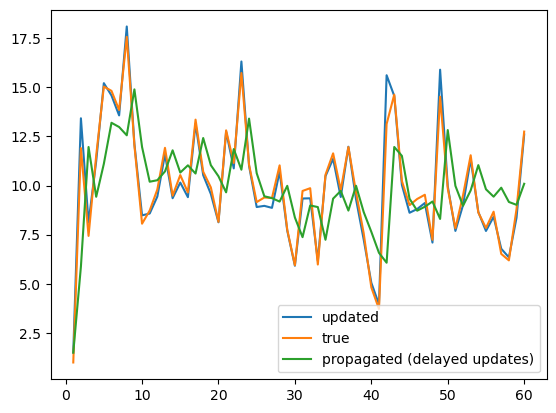

In [23]:
plt.plot(t_steps, updated_state_mean, label = "updated")
plt.plot(t_steps, true_state, label = "true")
plt.plot(t_steps, propagated_state_mean, label = "propagated (delayed updates)")
plt.legend()

## Ensemble KF : ToDo

In [21]:
import numpy as np
from Filtering.KalmanFilters import EnsembleKF
from Filtering.ExampleModels import SimpleModel
import matplotlib.pyplot as plt

In [10]:
np.random.seed(0)

In [13]:
omega = 4e-2
phi = 0.5
gamma_shape = 2
gamma_scale = 2
obs_noise_std = 0.5

simple_model = SimpleModel(omega, phi, gamma_shape, gamma_scale, obs_noise_std)

In [14]:
state_dim = 1
obs_dim = 1

true_init_state = 1.

t_steps = np.arange(1, 61, 1)*1.
n_steps = len(t_steps)

## Bootstrap PF

In [30]:
import numpy as np
from Filtering.ParticleFilters import BootstrapPF
from Filtering.ExampleModels import SimpleModel
import matplotlib.pyplot as plt

In [31]:
np.random.seed(0)

In [32]:
omega = 4e-2
phi = 0.5
gamma_shape = 2
gamma_scale = 2
obs_noise_std = 0.5

simple_model = SimpleModel(omega, phi, gamma_shape, gamma_scale, obs_noise_std)

In [33]:
state_dim = 1
obs_dim = 1

true_init_state = 1.

t_steps = np.arange(1, 61, 1)*1.
n_steps = len(t_steps)

In [34]:
n_particles = 200
n_steps_bw_resampling = 1

In [35]:
pf_obj = BootstrapPF(n_particles, state_dim, obs_dim, simple_model)

In [36]:
propagated_state_ensemble = np.zeros((n_steps, n_particles, state_dim))
updated_state_ensemble = np.zeros((n_steps, n_particles, state_dim))
resampled_state_ensemble = np.zeros((n_steps, n_particles, state_dim))

propagated_weight_ensemble = np.zeros((n_steps, n_particles))
updated_weight_ensemble = np.zeros((n_steps, n_particles))
resampled_weight_ensemble = np.zeros((n_steps, n_particles))

resampled_freq_vec = np.zeros((n_steps, n_particles))

In [37]:
## Initialize

propagated_state_ensemble[0, :, :] = np.random.uniform(true_init_state - 1, true_init_state + 1, 
                                                       (n_particles, state_dim))
updated_state_ensemble[0, :, :] =  propagated_state_ensemble[0, :, :]
resampled_state_ensemble[0, :, :] = propagated_state_ensemble[0, :, :]

propagated_weight_ensemble[0, :] = np.ones(n_particles)/n_particles
updated_weight_ensemble[0, :] = np.ones(n_particles)/n_particles
resampled_weight_ensemble[0, :] = np.ones(n_particles)/n_particles

resampled_freq_vec[0, :] = np.ones(n_particles)

In [38]:
for i in range(0, n_steps - 1):
#     print(i)
    current_time = t_steps[i]
    next_time = t_steps[i + 1]
    
    
    # Check if we should add noise here, I think it might be better to just add the mean since we
    # are interested in mean estimate of the state later
    propagated_state_ensemble[i + 1, :, :] = pf_obj.propagation(updated_state_ensemble[i, :, :], current_time,
                                                                aux_data = True)
    propagated_weight_ensemble[i + 1, :] = updated_weight_ensemble[i, :];
    
    [updated_state_ensemble[i + 1, :, :],
     updated_weight_ensemble[i + 1, :]] = pf_obj.update(propagated_state_ensemble[i + 1, :, :],
                                                        propagated_weight_ensemble[i + 1, :],
                                                        next_time, true_obs[i + 1, :])
    
    ## Resampling
    [resampled_state_ensemble[i + 1, :, :],
     resampled_weight_ensemble[i + 1, :],
     resampled_freq_vec[i + 1, :]] = pf_obj.resampling(updated_state_ensemble[i + 1, :, :],
                                                       updated_weight_ensemble[i + 1, :])
    
    if(i%n_steps_bw_resampling == 0):
        updated_state_ensemble[i + 1, :, :] = resampled_state_ensemble[i + 1, :, :]
        updated_weight_ensemble[i + 1, :] = resampled_weight_ensemble[i + 1, :]

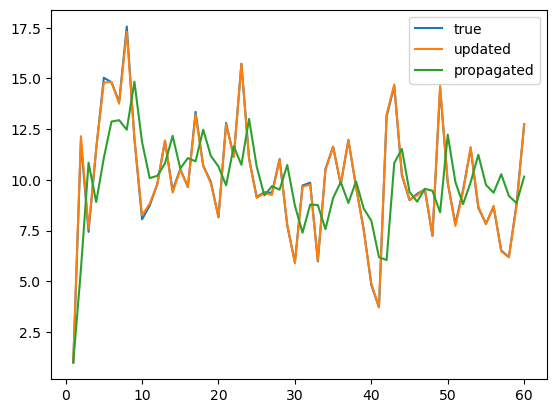

In [39]:
plt.plot(t_steps, true_state, label = "true")
plt.plot(t_steps, pf_obj.get_weighted_mean(updated_state_ensemble,
                                           updated_weight_ensemble), label = "updated")
plt.plot(t_steps, pf_obj.get_weighted_mean(propagated_state_ensemble,
                                           propagated_weight_ensemble), label = "propagated")
plt.legend()

## Unscented PF

In [40]:
import numpy as np
from Filtering.ParticleFilters import UnscentedPF
from Filtering.ExampleModels import SimpleModel
import matplotlib.pyplot as plt

In [41]:
np.random.seed(0)

In [42]:
omega = 4e-2
phi = 0.5
gamma_shape = 2
gamma_scale = 2
obs_noise_std = 0.5

simple_model = SimpleModel(omega, phi, gamma_shape, gamma_scale, obs_noise_std)

In [43]:
state_dim = 1
obs_dim = 1

true_init_state = 1.

t_steps = np.arange(1, 61, 1)*1.
n_steps = len(t_steps)

In [44]:
n_particles = 200
n_steps_bw_resampling_upf = 1

In [45]:
upf_obj = UnscentedPF(n_particles, state_dim, obs_dim, simple_model)

In [46]:
propagated_state_ensemble_upf = np.zeros((n_steps, n_particles, state_dim))
imp_sampling_state_ensemble_upf = np.zeros((n_steps, n_particles, state_dim))
updated_state_ensemble_upf = np.zeros((n_steps, n_particles, state_dim))
resampled_state_ensemble_upf = np.zeros((n_steps, n_particles, state_dim))

propagated_weight_ensemble_upf = np.zeros((n_steps, n_particles))
updated_weight_ensemble_upf = np.zeros((n_steps, n_particles))
resampled_weight_ensemble_upf = np.zeros((n_steps, n_particles))

obs_likelihood_ensemble_upf = np.zeros((n_steps, n_particles))
transition_probs_ensemble_upf = np.zeros((n_steps, n_particles))
imp_density_ensemble_upf = np.zeros((n_steps, n_particles))

resampled_freq_vec_upf = np.zeros((n_steps, n_particles))

In [47]:
## Initialize

propagated_state_ensemble_upf[0, :, :] = np.random.uniform(true_init_state - 1, true_init_state + 1,
                                                           (n_particles, state_dim))
imp_sampling_state_ensemble_upf[0, :, :] =  propagated_state_ensemble_upf[0, :, :]
updated_state_ensemble_upf[0, :, :] = propagated_state_ensemble_upf[0, :, :]
resampled_state_ensemble_upf[0, :, :] = propagated_state_ensemble_upf[0, :, :]

propagated_weight_ensemble_upf[0, :] = np.ones(n_particles)/n_particles
updated_weight_ensemble_upf[0, :] = np.ones(n_particles)/n_particles
resampled_weight_ensemble_upf[0, :] = np.ones(n_particles)/n_particles

obs_likelihood_ensemble_upf[0, :] = np.ones(n_particles)
transition_probs_ensemble_upf[0, :] = np.ones(n_particles)
imp_density_ensemble_upf[0, :] = np.ones(n_particles)

resampled_freq_vec_upf[0, :] = np.ones(n_particles)

In [48]:
for i in range(0, n_steps - 1):
    current_time = t_steps[i]
    next_time = t_steps[i + 1]
    
    propagated_state_ensemble_upf[i + 1, :, :] = upf_obj.propagation(updated_state_ensemble_upf[i, :, :],
                                                                 current_time, aux_data=True)
    propagated_weight_ensemble_upf[i + 1, :] = updated_weight_ensemble_upf[i, :]
    
    [imp_sampling_state_ensemble_upf[i + 1, :, :], 
     imp_density_ensemble_upf[i + 1, :]] = upf_obj.importance_sampling(updated_state_ensemble_upf[i, :, :],
                                                                       current_time, next_time, 
                                                                       true_obs[i + 1, :])
    updated_state_ensemble_upf[i + 1, :, :] = imp_sampling_state_ensemble_upf[i + 1, :, :]
    [updated_weight_ensemble_upf[i + 1, :],
     obs_likelihood_ensemble_upf[i + 1, :], 
     transition_probs_ensemble_upf[i + 1, :]] = upf_obj.weight_update(updated_state_ensemble_upf[i, :, :],
                                                    imp_sampling_state_ensemble_upf[i + 1, :, :],
                                                    imp_density_ensemble_upf[i + 1, :],
                                                    updated_weight_ensemble_upf[i, :], current_time,
                                                                     next_time, true_obs[i + 1, :])
    ## Resampling
    [resampled_state_ensemble_upf[i + 1, :, :],
     resampled_weight_ensemble_upf[i + 1, :],
     resampled_freq_vec_upf[i + 1, :]] = upf_obj.resampling(updated_state_ensemble_upf[i + 1, :, :],
                                                            updated_weight_ensemble_upf[i + 1, :])
    
    if(i%n_steps_bw_resampling_upf == 0):
        updated_state_ensemble_upf[i + 1, :, :] = resampled_state_ensemble_upf[i + 1, :, :]
        updated_weight_ensemble_upf[i + 1, :] = resampled_weight_ensemble_upf[i + 1, :]
    

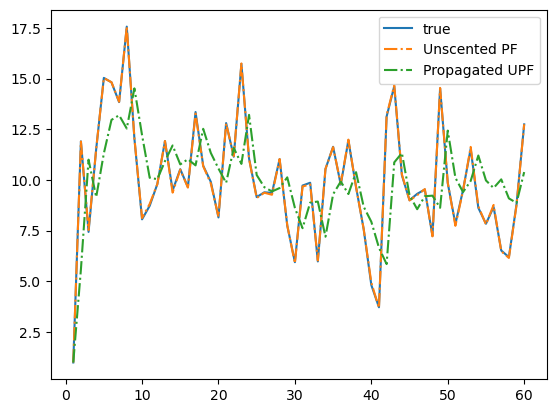

In [50]:
plt.plot(t_steps, true_state, label = "true")
plt.plot(t_steps, upf_obj.get_weighted_mean(updated_state_ensemble_upf,
                                           updated_weight_ensemble_upf), '-.', label = "Unscented PF")
plt.plot(t_steps, upf_obj.get_weighted_mean(propagated_state_ensemble_upf,
                                           propagated_weight_ensemble_upf), '-.', label = "Propagated UPF")
plt.legend()